# Content Based Filtering model

## Recommendation through Author of the book

This is the second notebook of Capstone Project. It contains section on:

### Contents:
- [Import Libraries](#Import=libraries)
- [Load Data](#Load-Data)
- [Filtering Books](#Filtering_books)
- [Modelling using TF-IDF](#Modelling-TF-IDF)
- [Metric Evaluation Using Cosine similarity](#Cosine_similarity)
- [Metric Evaluation Using Euclidean Distance](#Euclidean-Distance)
- [Metric Evaluation Using Pearson'sR Correlation](#Pearson-Correlation)
- [Conclusion](#Conclusion)


### Recommender System:
 
A Recommender System is a simple algorithm, whose aim is to provide the most relevant information to a user by discovering patterns in a dataset. 

### Content Based Recommender Systems:

It is born from the idea of using content of each item for recommending purposes. The content of an item is a very abstract thing and gives us a lot of options. We could use a lot of different variables. For example, for a book we could consider the author, genre, the text of the book itself... the list goes on.

This type of recommender uses the description of the item to recommend next most similar item. It uses the product features or keywords used in description to find the similarity between the items.

When we know which content we will consider(Book Author) , we need to transform this data into a Vector Space Model, an algebraic representation of text documents.

Generally, we do this with a Bag of Words model, that represents documents ignoring the order of the words. In this model, each document looks like a bag containing some words. Therefore this method allows word modelling based on dictionaries, where each bag contains a few words from the dictionary.

A specific implementation of a Bag of Words is the TF-IDF representation, where TF is for Term Frequency and IDF is Inverse Document Frequency. This model combines how important is the word in the document (local importance) with how important is the word in the corpus(global importance)



TF-IDF is used in Information Retrieval for feature extraction purposes and it is sub area of Natural Language Processing(NLP)

![TF](https://cdn-images-1.medium.com/max/800/1*5s81Q5RYPUSxDqPr0gG4qw.png)

![IDF](https://cdn-images-1.medium.com/max/800/1*BwOL05kcXjty9ctYUvntbQ.png)
 TF-IDF is a measure used to evaluate how important a word is to a document in a document corpus. The importance of the word increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.
 
 


### Load Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import pearsonr


To display all the rows of a column

In [2]:
pd.set_option('display.max_colwidth', -1)

## Load datasets

In [3]:
books= pd.read_csv('../datasets/cleaned_books.csv')
users = pd.read_csv('../datasets/cleaned_users.csv')
ratings = pd.read_csv('../datasets/cleaned_ratings.csv')

In [4]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &; Company


In [5]:
ratings.head()

,userID,ISBN,bookRating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276744,038550120X,7
4,276747,0060517794,9


In [6]:
#number of ratings received by each book
usersPerIsbn = ratings['ISBN'].value_counts()
usersPerIsbn

0316666343    707
0971880107    581
0385504209    487
0312195516    383
0060928336    320
059035342X    313
0142001740    307
0446672211    295
044023722X    281
0452282152    278
0316601950    272
0671027360    269
067976402X    256
0316769487    243
0786868716    242
0743418174    236
0345337662    230
0375727345    229
0156027321    226
0312278586    226
0060930535    218
0671021001    217
0440226430    214
0446310786    214
044021145X    208
0671003755    207
0446605239    206
043935806X    206
0345370775    200
0440241073    200
             ... 
0690012918    1  
082562536X    1  
0884362922    1  
1577310365    1  
0825699223    1  
0374522685    1  
0805063218    1  
0684189488    1  
0373835779    1  
0020804016    1  
0679765468    1  
059509354X    1  
3485003220    1  
1855926318    1  
0945564295    1  
207054138X    1  
8478082441    1  
9176437752    1  
0207180342    1  
0966579828    1  
0698200446    1  
0671867784    1  
0443045607    1  
0593041887    1  
0195401697

Filtering books with more than 10 ratings from users

In [7]:
books_10 = books[books['ISBN'].isin(usersPerIsbn[usersPerIsbn > 10].index)]

In [8]:
books_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4788 entries, 5 to 121149
Data columns (total 5 columns):
ISBN                 4788 non-null object
bookTitle            4788 non-null object
bookAuthor           4788 non-null object
yearOfPublication    4734 non-null float64
publisher            4788 non-null object
dtypes: float64(1), object(4)
memory usage: 224.4+ KB


### Using bookTitle only for TFIDF

#### PreProcessing

It is one of the major steps when we are dealing with any kind of text models. This step never had one hot rule and totally depends on the problem statement. Few mandatory pre processing are converting to lowercase, removing punctuation, removing stopwords and lemmatization/stemming.

In our problem statement it seems like the basic preprocessing steps will be sufficient.
Stopwords:
They are the most commonly occuring words which don't give additional value to the document vector. Infact, removing these will increase computation and space efficiency.

In [9]:
# removing the stopwords
stopwords_list = stopwords.words('english')

We cannot compute the similarity between the given description in the form it is in our dataset. For this purpose, TF-IDF is calculated for all the documents which would simply return you a matrix with each word representing a column. TFIDF Vectorizer would do this for us in a couple of lines.

In [10]:
#Fit the transformer

vectorizer = TfidfVectorizer(analyzer = 'word')

In [11]:
# computing bookTitle tfidf matrix 
tfidf_matrix = vectorizer.fit_transform(books_10['bookAuthor'])
tfidf_matrix

<4788x1963 sparse matrix of type '<class 'numpy.float64'>'
	with 9841 stored elements in Compressed Sparse Row format>

In [12]:
tfidf_matrix.shape

(4788, 1963)

The above shape means that 1963 words are used to describe 4788 book authors in our dataset.

In [13]:
tfidf_feature_name = vectorizer.get_feature_names()
tfidf_feature_name

['abbey',
 'abbott',
 'ablow',
 'abraham',
 'achebe',
 'ackerman',
 'adam',
 'adams',
 'adele',
 'adeline',
 'adriana',
 'agatha',
 'agatston',
 'ahdaf',
 'akif',
 'al',
 'alan',
 'albert',
 'albom',
 'alcott',
 'aldo',
 'aldous',
 'alessandro',
 'alex',
 'alexander',
 'alexandra',
 'alexandre',
 'alexie',
 'alfred',
 'ali',
 'alice',
 'alisa',
 'alison',
 'allan',
 'allen',
 'allenbaugh',
 'allende',
 'allison',
 'alvarez',
 'amanda',
 'amber',
 'ambrose',
 'amelia',
 'amelie',
 'ammaniti',
 'amory',
 'amy',
 'anais',
 'anastas',
 'anatoli',
 'anatolian',
 'anaya',
 'anderson',
 'andre',
 'andrea',
 'andrew',
 'andrews',
 'andy',
 'angela',
 'angelou',
 'angier',
 'anita',
 'ann',
 'anna',
 'anne',
 'annette',
 'annie',
 'anonymous',
 'ansay',
 'anthony',
 'antoine',
 'anton',
 'antwone',
 'apkarian',
 'applegate',
 'arabella',
 'archer',
 'ariel',
 'arlene',
 'armistead',
 'armstrong',
 'art',
 'arthur',
 'arturo',
 'arundhati',
 'ashley',
 'asimov',
 'asprin',
 'astrid',
 'atkins',


In [14]:
#computing cosine similarity using linear_kernal of sklearn
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix )
cosine_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [15]:
books_10 = books_10.reset_index(drop = True)
books_10

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group
1,0440234743,The Testament,John Grisham,1999.0,Dell
2,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume
3,0609804618,Our Dumb Century: The Onion Presents 100 Years of Headlines from America's Finest News Source,The Onion,1999.0,Three Rivers Press
4,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far
5,0345402871,Airframe,Michael Crichton,1997.0,Ballantine Books
6,0345417623,Timeline,MICHAEL CRICHTON,2000.0,Ballantine Books
7,0375759778,Prague : A Novel,ARTHUR PHILLIPS,2003.0,Random House Trade Paperbacks
8,0446310786,To Kill a Mockingbird,Harper Lee,1988.0,Little Brown &; Company
9,0449005615,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002.0,Ballantine Books


In [16]:
indices = pd.Series(books_10['ISBN'])


we are using dictionary to hold our dataset, what we are going to do is we will iterate over all of values in the dictionary and check if the value is present in the token. 

Let's convert the query and documents to vectors. We are going to use total_vocab variable which has all the list of unique tokens to generate a index for each token and we will use numpy of shape(docs, total_vocab) to store the document vectors.



In [17]:
inddict = indices.to_dict()

In [18]:
inddict = dict((v,k) for k,v in inddict.items())

### By Cosine similarity

Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.
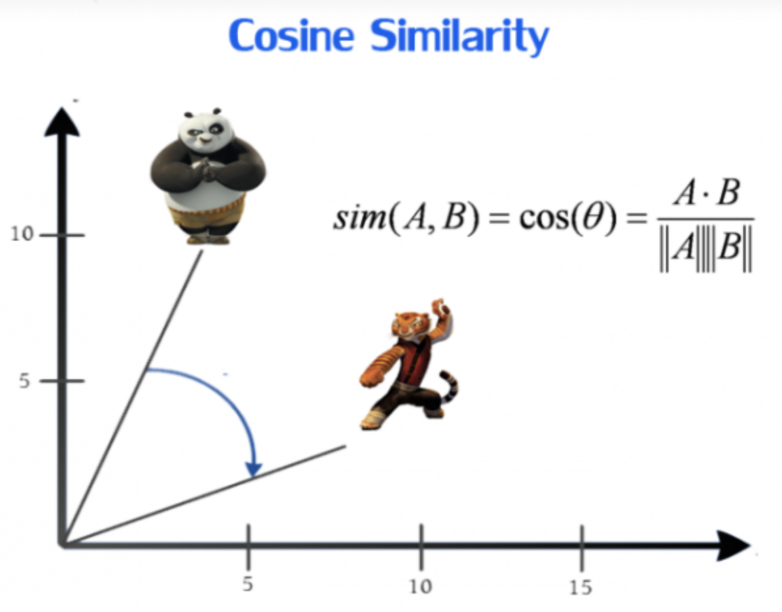


In [19]:
# Function to get the most similar books
def recommend_cosine(isbn):
    id = inddict[isbn]
    #Get the pairwise similarity scores of all books compared to that books
    #sorting them ang getting top 5
    similarity_scores = list(enumerate(cosine_similarity[id]))
    similarity_scores = sorted(similarity_scores, key =lambda x : x[1], reverse = True)
    similarity_scores = similarity_scores[1:6]
    
    # Get the books index
    books_index = [i[0] for i in similarity_scores]
    
    #Return the top 5 most similar books using iloc
    return books_10.iloc[books_index]
    
    

In [20]:
recommend_cosine("0399135782")

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
21,0804106304,The Joy Luck Club,Amy Tan,1994.0,Prentice Hall (K-12)
486,080410753X,The Kitchen God's Wife,Amy Tan,1992.0,Ivy Books
904,0399146431,The Bonesetter's Daughter,Amy Tan,2001.0,Putnam Publishing Group
906,0399141146,The Hundred Secret Senses,Amy Tan,1995.0,Putnam Pub Group
1612,0804114986,The Bonesetter's Daughter,Amy Tan,2002.0,Ballantine Books


### Euclidean Distance
Similar items will lie in close proximity to each other if plotted in n-dimensional space. So, we can calculate the distance between items and based on that distance, recommend items to the user. 
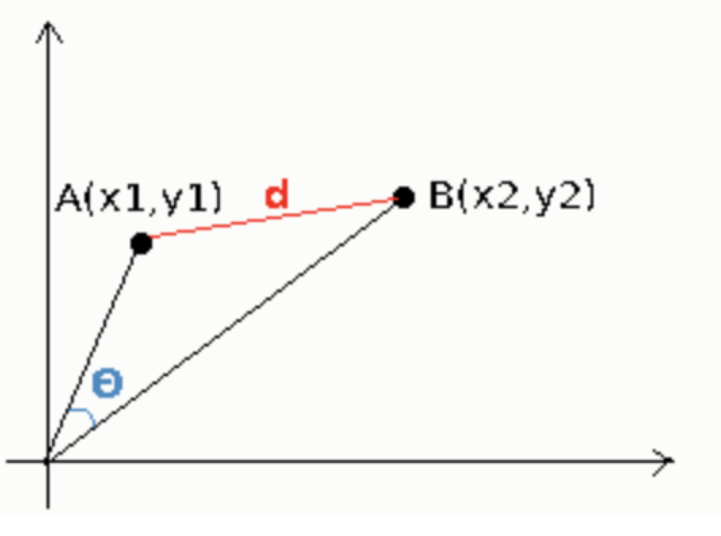


In [21]:
eucli_distance = euclidean_distances(tfidf_matrix)

In [22]:
def recommend_euclidean_distance(isbn):
    ind = inddict[isbn]
    distance = list(enumerate(eucli_distance[ind]))
    distance = sorted(distance,key = lambda x : x[1])
    distance = distance[1:6]
    
    # Get the books index
    books_index = [i[0] for i in distance]
    
    #Return the top 5 most similar books using iloc
    return books_10.iloc[books_index]
        
    

In [23]:
recommend_euclidean_distance("0399135782")

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
21,0804106304,The Joy Luck Club,Amy Tan,1994.0,Prentice Hall (K-12)
486,080410753X,The Kitchen God's Wife,Amy Tan,1992.0,Ivy Books
904,0399146431,The Bonesetter's Daughter,Amy Tan,2001.0,Putnam Publishing Group
906,0399141146,The Hundred Secret Senses,Amy Tan,1995.0,Putnam Pub Group
1612,0804114986,The Bonesetter's Daughter,Amy Tan,2002.0,Ballantine Books


### Pearson's Correlation

It tells us how much two items are correlated. Higher the correlation, more will be the similarity. 

In [24]:
tfidf_matrix_array = tfidf_matrix.toarray()

In [25]:
def recommend_pearson(isbn):
    id = inddict[isbn]
    correlation = []
    for i in range(len(tfidf_matrix_array)):
        correlation.append(pearsonr(tfidf_matrix_array[id],tfidf_matrix_array[i])[0])
    correlation = list(enumerate(correlation))
    sorted_corr = sorted(correlation, reverse = True, key = lambda x : x[1])[1:6]
    books_index = [i[0] for i in sorted_corr]
    return books_10.iloc[books_index]

In [26]:
recommend_pearson('0399135782')

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
21,0804106304,The Joy Luck Club,Amy Tan,1994.0,Prentice Hall (K-12)
486,080410753X,The Kitchen God's Wife,Amy Tan,1992.0,Ivy Books
904,0399146431,The Bonesetter's Daughter,Amy Tan,2001.0,Putnam Publishing Group
906,0399141146,The Hundred Secret Senses,Amy Tan,1995.0,Putnam Pub Group
1612,0804114986,The Bonesetter's Daughter,Amy Tan,2002.0,Ballantine Books


We did matching score using cosine similarity, Euclidean Distance and PearsonR correlation.

Our query was the bookauthor Amy Tan and we found all the books written by Amy Tan. By this we can say that our recommendation engine is working. 

### Conclusion

A major drawback of this content based filtering is that it is limited to recommending items that are of the same type. It will never recommend products which the user has not bought or liked in the past. So, if a user has read a book written by Amy Tan in the past, then the system will recommend only books written by Amy Tan.
Its a very narrow way of building an engine. 
To improve on this type of system, we need an algorithm that can recommend items not just based on the content but the behaviour of users as well.